In [7]:
import sys
import os
import time
import string
import random
import pickle

import numpy as np

# for the larger networks (n>=9), we need to adjust pythons recursion limit
sys.setrecursionlimit(10000)

# ##################### Load data from CIFAR-10 dataset #######################
# this code assumes the cifar dataset from 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# has been extracted in current working directory
def unpickle(file):
    import cloudpickle
    fo = open(file, 'rb')
    print (fo)
    dict = cloudpickle.load(fo, encoding='bytes')
    fo.close()
    return dict

def load_data():
    xs = []
    ys = []
    for j in range(5):
        d = unpickle('cifar-10-batches-py/data_batch_'+str(j+1))
        x = d[b'data']
        y = d[b'labels']
        xs.append(x)
        ys.append(y)

    x = np.concatenate(xs)
    y = np.concatenate(ys).astype(np.int32)


    d = unpickle('cifar-10-batches-py/test_batch')
    x_test = d[b'data']
    y_test = np.array(d[b'labels'],dtype=np.int32)

    X_train = np.reshape(x, (x.shape[0], -1)) 
    X_test = np.reshape(x_test, (x_test.shape[0], -1))



    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

    return X_train, y, X_test, y_test

data_X_train, data_Y_train, data_X_test, data_Y_test = load_data()


D = data_X_train.shape[1]
K = np.unique(data_Y_train).shape[0] #Y_train.shape[1]

print (D,K)


<_io.BufferedReader name='cifar-10-batches-py/data_batch_1'>
<_io.BufferedReader name='cifar-10-batches-py/data_batch_2'>
<_io.BufferedReader name='cifar-10-batches-py/data_batch_3'>
<_io.BufferedReader name='cifar-10-batches-py/data_batch_4'>
<_io.BufferedReader name='cifar-10-batches-py/data_batch_5'>
<_io.BufferedReader name='cifar-10-batches-py/test_batch'>
3073 10


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
data_Y_train=np.asarray(data_Y_train)
data_Y_test=np.asarray(data_Y_test)


In [10]:
def classifier(X,y,s,r,g_iter):
    #Perform batch SGD using backprop
    D = X.shape[1] #Number of features
    K = 10 #Number of classes assuming class index starts from 0

    # Start with an initialize parameters randomly

    
    # Initial values from hyperparameter
    reg = r # regularization strength
    
    np.random.seed(1234)
    W = 0.01 * np.random.randn(D,K)
    b = np.zeros((1,K))
#For simplicity we will take the batch size to be the same as number of examples
    num_examples = X.shape[0]
    
    #Initial value for the Gradient Descent Parameter
    step_size = s #Also called learning rate

    #For simplicity, we will not hand tune this algorithm parameter as well.

    # gradient descent loop
    for i in range(g_iter):
  
    # evaluate class scores, [N x K]
        scores = 0.01*np.dot(X, W) + b 
        
    # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    
    # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W)
        loss = data_loss + reg_loss
        #if i % 0 == 0:
            #print ("iteration %d: loss %f" % (i, loss))
  
    # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
        dW = np.dot(X.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
  
        dW += reg*W # regularization gradient
  
    # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
    
    return(W,b)

In [11]:
#Question 6.2.4.3
W,b= classifier(data_X_train,data_Y_train,0.00001,0.002,4)

scores = np.dot(data_X_train, W) + b
predicted_class = np.argmax(scores, axis=1)

print ('train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

scores = np.dot(data_X_test,W) + b
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

train accuracy: 15.09
Test accuracy: 15.11


In [13]:
#Question 6.2.4.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(data_X_train), n_folds=4,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = data_X_train.shape[1] #Number of features
K = 10 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = data_X_train[traincv], data_X_train[testcv]
    y_train, y_test = data_Y_train[traincv], data_Y_train[testcv]
    W1,b1=classifier(X_train,y_train,0.00001,0.002,4)
       #print(type(X[testcv]))
    #print(W1,b1)
    
    scores = np.dot(X_test, W1) + b1
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc) 


Validation Accuracy: 15.11
Test Accuracy: 15.11


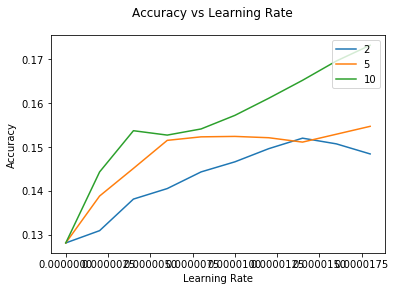

In [10]:
#Question 6.2.4.5
regu_rate=[]
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[2,5,10]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(10):
        learning_rate.append(0.000002*i)
        W1,b1= classifier(data_X_train,data_Y_train,0.000002*i,0.002,j)
        scores = np.dot(data_X_test, W1) + b1
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['2', '5', '10'], loc='upper right')
plt.show()


4


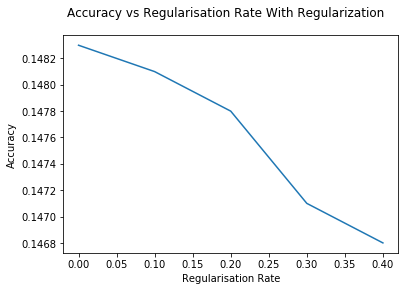

Best Accuracy with Regularization parameter  : 14.83 
Best Regularization parameter with Regularization parameter : 0.00000
Best Accuracy without Regularization parameter  : 10.27 


In [37]:
#Question 6.2.4.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(5):
    regu_rate.append(0.1*j)
    W1,b1= classifier(data_X_train,data_Y_train,0.0001,0.1*j,10)
    scores1 = np.dot(data_X_test, W1) + b1
    predicted_class = np.argmax(scores1, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
print(j)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W2,b2= classifier(data_X_train,data_Y_train,0.0001,0,5)
scores2 = np.dot(data_X_test, W2) + b2
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))
max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))


In [20]:
#Question 6.2.4.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(data_X_train, data_Y_train, test_size=0.50)
W1_50,b1_50=classifier(data_X_train50,data_Y_train50,0.0001,0.0001,20)
train_scores50=np.dot(data_X_train50,W1_50) + b1_50
test_scores50 = np.dot(data_X_test50, W1_50) + b1_50
predicted_class_train50 = np.argmax(train_scores50, axis=1)
predicted_class_test50 = np.argmax(test_scores50, axis=1)
print (' Train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class_train50 == data_Y_train50)*100))
Test_Acc50=(np.mean(predicted_class_test50 == data_Y_test50)*100)
print (' Test accuracy with 50:50 split: %.2f' % Test_Acc50)

 Train accuracy with 50:50 split: 13.44
 Test accuracy with 50:50 split: 12.77


In [21]:
def ffn(X,y,s,r,g_iter):
    
    
    #For simplicity we will take the batch size to be the same as number of examples
    num_examples = X.shape[0]
    h = 100
    D = data_X_train.shape[1] #Number of features
    K = 10 #Number of classes assuming class index starts from 0

    np.random.seed(1234)
    W = 0.01 * np.random.randn(D,h)
    b = np.zeros((1,h))
    W2 = 0.01 * np.random.randn(h,K)
    b2 = np.zeros((1,K))
    
    #Initial value for the Gradient Descent Parameter
    step_size = s #Also called learning rate

    #For simplicity, we will not hand tune this algorithm parameter as well.
    reg= r
    
    # gradient descent loop
    for i in range(g_iter):
      
  # evaluate class scores, [N x K]
        hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        if i % 1 == 0:
            print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
  # finally into W,b
        dW = np.dot(X.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W
  
  # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        
    return(W,b,W2,b2)

In [27]:
#Question 6.2.5.1.3
#Question 5.1.3

W,b,W2,b2= ffn(data_X_train,data_Y_train,0.0001,0.001,30)

hidden_layer = np.maximum(0, np.dot(data_X_train, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(0, np.dot(data_X_test, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

iteration 0: loss 5.874643
iteration 1: loss 5.397032
iteration 2: loss 4.714857
iteration 3: loss 4.213515
iteration 4: loss 3.856175
iteration 5: loss 3.755358
iteration 6: loss 3.597151
iteration 7: loss 3.466734
iteration 8: loss 3.343302
iteration 9: loss 3.206605
iteration 10: loss 3.280949
iteration 11: loss 3.036332
iteration 12: loss 3.005789
iteration 13: loss 2.938433
iteration 14: loss 2.901243
iteration 15: loss 2.832513
iteration 16: loss 2.801928
iteration 17: loss 2.770897
iteration 18: loss 2.730775
iteration 19: loss 2.693562
train accuracy: 17.90
Test accuracy: 18.65


In [30]:
#Question 6.2.5.1.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(data_X_train), n_folds=4,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = data_X_train.shape[1] #Number of features
K = 10 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = data_X_train[traincv], data_X_train[testcv]
    y_train, y_test = data_Y_train[traincv], data_Y_train[testcv]
    W,b,W2,b2=ffn(X_train,y_train,0.0001,0.001,10)
    
    hidden_layer = np.maximum(0, np.dot(X_test, W) + b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc) 

iteration 0: loss 5.866680
iteration 1: loss 5.393429
iteration 2: loss 4.717552
iteration 3: loss 4.179281
iteration 4: loss 3.840574
iteration 5: loss 3.741885
iteration 6: loss 3.597392
iteration 7: loss 3.449218
iteration 8: loss 3.328888
iteration 9: loss 3.203700
iteration 0: loss 5.861747
iteration 1: loss 5.363438
iteration 2: loss 4.686745
iteration 3: loss 4.197177
iteration 4: loss 3.831827
iteration 5: loss 3.733120
iteration 6: loss 3.585769
iteration 7: loss 3.463397
iteration 8: loss 3.312746
iteration 9: loss 3.183411
iteration 0: loss 5.869391
iteration 1: loss 5.383021
iteration 2: loss 4.696195
iteration 3: loss 4.216802
iteration 4: loss 3.842903
iteration 5: loss 3.744025
iteration 6: loss 3.552798
iteration 7: loss 3.462192
iteration 8: loss 3.339959
iteration 9: loss 3.166220
iteration 0: loss 5.838909
iteration 1: loss 5.386194
iteration 2: loss 4.697804
iteration 3: loss 4.200328
iteration 4: loss 3.848224
iteration 5: loss 3.736956
iteration 6: loss 3.588063
i

iteration 0: loss 5.859182
iteration 1: loss 5.859182
iteration 0: loss 5.859182
iteration 1: loss 5.017734
iteration 0: loss 5.859182
iteration 1: loss 6.623309
iteration 0: loss 5.859182
iteration 1: loss 8.521045
iteration 0: loss 5.859182
iteration 1: loss 10.709314
2
iteration 0: loss 5.859182
iteration 1: loss 5.859182
iteration 2: loss 5.859182
iteration 3: loss 5.859182
iteration 4: loss 5.859182
iteration 0: loss 5.859182
iteration 1: loss 5.017734
iteration 2: loss 4.131898
iteration 3: loss 3.780460
iteration 4: loss 3.449204
iteration 0: loss 5.859182
iteration 1: loss 6.623309
iteration 2: loss 6.595865
iteration 3: loss 5.229590
iteration 4: loss 4.546838
iteration 0: loss 5.859182
iteration 1: loss 8.521045
iteration 2: loss 9.822992
iteration 3: loss 6.563641
iteration 4: loss 3.901970
iteration 0: loss 5.859182
iteration 1: loss 10.709314
iteration 2: loss 14.416281
iteration 3: loss 9.493930
iteration 4: loss 2.427231
5
iteration 0: loss 5.859182
iteration 1: loss 5.8

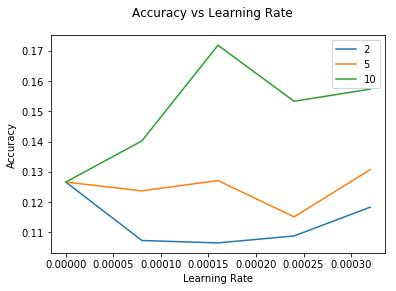

In [34]:
#Question 6.2.5.1.5
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[2,5,10]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(5):
        learning_rate.append(0.00008*i)
        W,b,W2,b2= ffn(data_X_train,data_Y_train,0.00008*i,0.001,j)
        hidden_layer = np.maximum(0, np.dot(data_X_test, W) + b)
        scores = np.dot(hidden_layer, W2) + b2
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
    print(j)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['2', '5', '10'], loc='upper right')
plt.show()

iteration 0: loss 5.843721
iteration 1: loss 5.366113
iteration 2: loss 4.683941
iteration 3: loss 4.182602
iteration 4: loss 3.825261
iteration 5: loss 3.724444
iteration 6: loss 3.566246
iteration 7: loss 3.435827
iteration 8: loss 3.312394
iteration 9: loss 3.175698
iteration 0: loss 7.389793
iteration 1: loss 6.912028
iteration 2: loss 6.229699
iteration 3: loss 5.728217
iteration 4: loss 5.370760
iteration 5: loss 5.269818
iteration 6: loss 5.111492
iteration 7: loss 4.980975
iteration 8: loss 4.857539
iteration 9: loss 4.720733
iteration 0: loss 8.935866
iteration 1: loss 8.457881
iteration 2: loss 7.775332
iteration 3: loss 7.273651
iteration 4: loss 6.916014
iteration 5: loss 6.814879
iteration 6: loss 6.656375
iteration 7: loss 6.525717
iteration 8: loss 6.402184
iteration 9: loss 6.265204
iteration 0: loss 10.481938
iteration 1: loss 10.003672
iteration 2: loss 9.320856
iteration 3: loss 8.818910
iteration 4: loss 8.461010
iteration 5: loss 8.359639
iteration 6: loss 8.200896

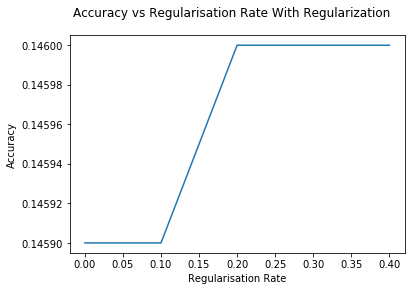

Best Accuracy with Regularization parameter  : 14.60 
Best Regularization parameter with Regularization parameter : 0.20000
iteration 0: loss 5.843721
iteration 1: loss 5.366113
iteration 2: loss 4.683941
iteration 3: loss 4.182602
iteration 4: loss 3.825261
iteration 5: loss 3.724444
iteration 6: loss 3.566246
iteration 7: loss 3.435827
iteration 8: loss 3.312394
iteration 9: loss 3.175698
Best Accuracy without Regularization parameter  : 14.59 


In [41]:
#Question 6.2.5.1.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(5):
    regu_rate.append(0.1*j)
    W,b,W2,b2= ffn(data_X_train,data_Y_train,0.0001,0.1*j,10)
    hidden_layer = np.maximum(0, np.dot(data_X_test, W) + b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W,b,W2,b2= ffn(data_X_train,data_Y_train,0.0001,0,10)
hidden_layer = np.maximum(0, np.dot(data_X_test, W) + b)
scores2 = np.dot(hidden_layer, W2) + b2
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))
max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))

In [45]:
#Question 6.2.5.1.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(data_X_train, data_Y_train, test_size=0.50)
W,b,W2,b2=ffn(data_X_train50,data_Y_train50,0.0001,0.00001,20)
hidden_layer = np.maximum(0, np.dot(data_X_train, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(0, np.dot(data_X_test, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy with 50:50 split: %.2f' % Test_Acc)

iteration 0: loss 5.858971
iteration 1: loss 5.356584
iteration 2: loss 4.691934
iteration 3: loss 4.152427
iteration 4: loss 3.811195
iteration 5: loss 3.717640
iteration 6: loss 3.593208
iteration 7: loss 3.450426
iteration 8: loss 3.295110
iteration 9: loss 3.177057
iteration 10: loss 3.267640
iteration 11: loss 3.007109
iteration 12: loss 2.976079
iteration 13: loss 2.890727
iteration 14: loss 2.855252
iteration 15: loss 2.798534
iteration 16: loss 2.765432
iteration 17: loss 2.734812
iteration 18: loss 2.696344
iteration 19: loss 2.657940
train accuracy with 50:50 split: 17.96
Test accuracy with 50:50 split: 18.54


In [46]:
#Question 6.2.5.2
def ffnl(X,y,s,r,g_iter):
    #For simplicity we will take the batch size to be the same as number of examples
    num_examples = X.shape[0]
    h = 100
    np.random.seed(1234)
    W = 0.01 * np.random.randn(D,h)
    b = np.zeros((1,h))
    W2 = 0.01 * np.random.randn(h,K)
    b2 = np.zeros((1,K))
    
    #Initial value for the Gradient Descent Parameter
    step_size = s #Also called learning rate

    #For simplicity, we will not hand tune this algorithm parameter as well.
    reg= r
    
    # gradient descent loop
    for i in range(g_iter):
      
  # evaluate class scores, [N x K]
        #hidden_layer = np.maximum(0.01*x, np.dot(X, W) + b)# note, ReLU activation
        hidden_layer = np.maximum(np.dot(0.01*X,W)+b  , np.dot(X,W)+ b) # Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2
         
  # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        #if i % 1000 == 0:
            #print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] *= 0.01
  # finally into W,b
        dW = np.dot(X.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W
  
  # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        
    return(W,b,W2,b2)

In [50]:
#Question 6.2.5.2.3

W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.0001,0.0001,10)

hidden_layer = np.maximum(np.dot(0.01*data_X_train,W)+b  , np.dot(data_X_train,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

train accuracy: 14.41
Test accuracy: 14.45


In [54]:
#Question 6.2.5.2.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(data_X_train), n_folds=10,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = data_X_train.shape[1] #Number of features
K = 10 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = data_X_train[traincv], data_X_train[testcv]
    y_train, y_test = data_Y_train[traincv], data_Y_train[testcv]
    W,b,W2,b2=ffnl(X_train,y_train,0.0001,0.001,3)
    
    hidden_layer = np.maximum(np.dot(0.01*X_test,W)+b  , np.dot(X_test,W)+ b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc)

Validation Accuracy: 12.79
Test Accuracy: 14.45


2
5
10


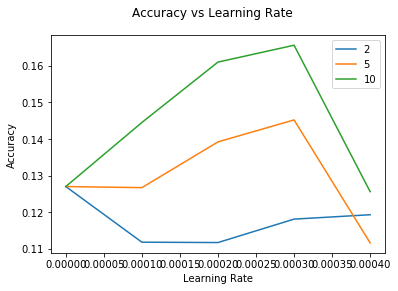

In [58]:
#Question 6.2.5.2.5
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[2,5,10]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(5):
        learning_rate.append(0.0001*i)
        W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.0001*i,0.001,j)
        hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
        scores = np.dot(hidden_layer, W2) + b2
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
    print(j)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['2', '5', '10'], loc='upper right')
plt.show()

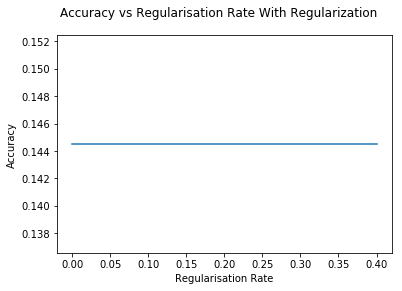

Best Accuracy with Regularization parameter  : 14.45 
Best Regularization parameter with Regularization parameter : 0.00000
Best Accuracy without Regularization parameter  : 14.45 


In [60]:
#Question 6.2.5.2.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(5):
    regu_rate.append(0.1*j)
    W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.0001,0.1*j,10)
    hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.0001,0.1*j,10)
hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores2 = np.dot(hidden_layer, W2) + b2
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))
max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))

In [63]:
#Question 6.2.5.2.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(data_X_train, data_Y_train, test_size=0.50)
W,b,W2,b2=ffnl(data_X_train50,data_Y_train50,0.0001,0.001,5)
hidden_layer = np.maximum(np.dot(0.01*data_X_train,W)+b  , np.dot(data_X_train,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy with 50:50 split: %.2f' % Test_Acc)

train accuracy with 50:50 split: 12.53
Test accuracy with 50:50 split: 12.81


In [64]:
def ffnmo(X,y,step_size, reg, no_iter):
        
    # Start with an initial set of parameters randomly
    h1 = 100 # size of hidden layer1
    #h2 = 100 # size of hidden layer2
    np.random.seed(1234)
    W1 = 0.01 * np.random.randn(D,h1)
    b1 = np.zeros((1,h1))
    W2 = 0.01 * np.random.randn(D,h1)
    b2 = np.zeros((1,h1))
    W3 = 0.01 * np.random.randn(h1,K)
    b3 = np.zeros((1,K))

    num_examples = X.shape[0]

    # gradient descent loop
    for i in range(no_iter):

        # evaluate class scores, [N x K]
        #hidden_layer1 = np.maximum(0, np.dot(X, W1) + b1) # note, ReLU activation
        #hidden_layer2 = np.maximum(0, np.dot(X, W2) + b2) # note, ReLU activation
        hidden_layer = np.maximum(np.dot(X, W1) + b1, np.dot(X, W2) + b2) # note, ReLU activation
        scores = np.dot(hidden_layer, W3) + b3

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        #if i % 1000 == 0:
            #print "iteration %d: loss %f" % (i, loss)

        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
        
        dW3 = np.dot(hidden_layer.T, dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        #dhidden[hidden_layer <= 0] = 0
        dhidden2 = np.where(np.dot(X, W2) + b2 >= np.dot(X, W1) + b1, np.dot(dscores, W3.T), 0)
        dhidden  = np.where(np.dot(X, W2) + b2 <= np.dot(X, W1) + b1, np.dot(dscores, W3.T), 0)
  
        # finally into W,b, W2,b2
  
        dW2 = np.dot(X.T, dhidden2)
        db2 = np.sum(dhidden2, axis=0, keepdims=True)
        dW1 = np.dot(X.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        

        # add regularization gradient contribution
        dW3 += reg * W3
        dW2 += reg * W2
        dW1 += reg * W1

        # perform a parameter update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    return(W1,b1,W2,b2,W3,b3)

In [65]:
#Question 6.2.5.3.3
#Evaluate the Train and Test Accuracy

W1,b1,W2,b2,W3,b3 = ffnmo(data_X_train,data_Y_train, 0.0001,0.0005,5)
hidden_layer = np.maximum(np.dot(data_X_train, W1) + b1, np.dot(data_X_train, W2) + b2) # note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
print ('Train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))


hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

Train accuracy: 14.56
Test accuracy: 14.48


In [68]:
#Question 6.2.5.3.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(data_X_train), n_folds=10,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = data_X_train.shape[1] #Number of features
K = 10 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = data_X_train[traincv], data_X_train[testcv]
    y_train, y_test = data_Y_train[traincv], data_Y_train[testcv]
    W1,b1,W2,b2,W3,b3 = ffnmo(X_train,y_train, 0.0001,0.001,3)
    hidden_layer = np.maximum(np.dot(X_test, W1) + b1, np.dot(X_test, W2) + b2) # note, ReLU activation
    scores = np.dot(hidden_layer, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc) 


Validation Accuracy: 14.65
Test Accuracy: 14.48


2
5


C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in maximum
C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: invalid value encountered in less_equal


10


C:\Users\adity\.conda\envs\py35\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in maximum


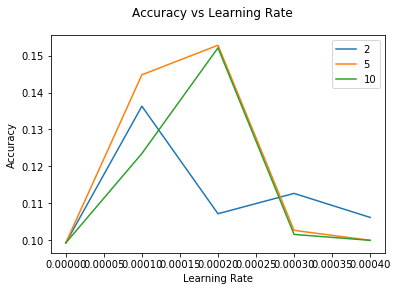

In [69]:
#Question 6.2.5.3.5
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[2,5,10]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(5):
        learning_rate.append(0.0001*i)
        W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.0001*i,0.001,j)
        hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
        scores = np.dot(hidden_layer, W3) + b3
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
    print(j)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['2', '5', '10'], loc='upper right')
plt.show()

In [ ]:
#Question 6.2.5.3.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(5):
    regu_rate.append(0.005*j)
    W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.0001,0.005*j,3)
    hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2)# note, ReLU activation
    scores = np.dot(hidden_layer, W3) + b3
    
    predicted_class = np.argmax(scores, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W1,b1,W2,b2,W3,b3= ffnmo(data_X_train,data_Y_train,0.4,0,3)
hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2) # note, ReLU activation
scores2 = np.dot(hidden_layer, W3) + b3
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))


max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))

In [ ]:
#Question 6.2.5.3.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(X, y, test_size=0.50)
W1,b1,W2,b2,W3,b3=ffnmo(data_X_train50,data_Y_train50,0.7,0.001,5)
hidden_layer = np.maximum(np.dot(data_X_train, W1) + b1, np.dot(data_X_train, W2) + b2)# note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(data_X_test, W1) + b1, np.dot(data_X_test, W2) + b2)# note, ReLU activation
scores = np.dot(hidden_layer, W3) + b3
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy with 50:50 split: %.2f' % Test_Acc)